In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [182]:
path = '/Users/iamyoungjin/Desktop/Nottingham Modules/Term1/ML/Assignment2/TrainDataset2023.xls'
df = pd.read_excel(path)
df = df.drop('ID', axis=1)

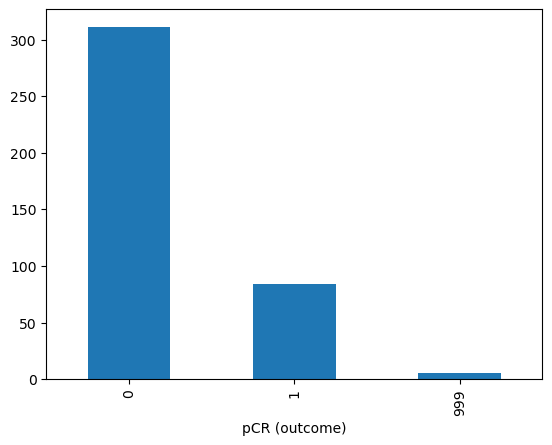

In [183]:
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

In [184]:
# change "999" to NaN
df.replace(999, pd.NA, inplace=True)

# Finding missing value 
columns_with_missing_values = df.columns[df.isnull().any()]
print("Columns which has missing values:", columns_with_missing_values)

Columns which has missing values: Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus'],
      dtype='object')


In [185]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

for column, value in missing_data.items():
    if value != 0:
        print(f"colum:{column}, {missing_data[column]}")
        print(f"colum:{column}, {missing_percentage[column]}%")

colum:pCR (outcome), 5
colum:pCR (outcome), 1.25%
colum:PgR, 1
colum:PgR, 0.25%
colum:HER2, 1
colum:HER2, 0.25%
colum:TrippleNegative, 1
colum:TrippleNegative, 0.25%
colum:ChemoGrade, 3
colum:ChemoGrade, 0.75%
colum:Proliferation, 2
colum:Proliferation, 0.5%
colum:HistologyType, 3
colum:HistologyType, 0.75%
colum:LNStatus, 1
colum:LNStatus, 0.25%


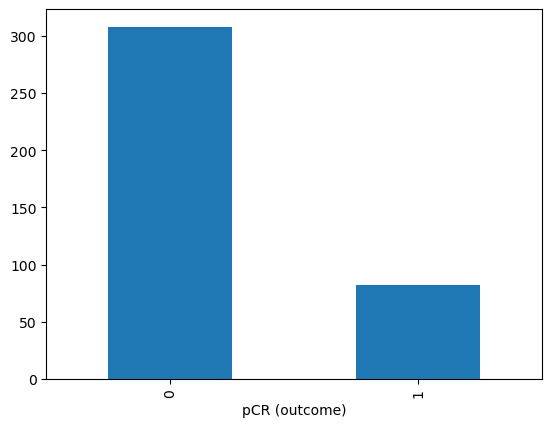

In [186]:
missing_data = df.isnull().sum()
df = df.dropna()
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

In [187]:
pCR_label = df['pCR (outcome)'] # Classlification Label
RelapseFreeSurvival_label = df['RelapseFreeSurvival (outcome)'] # Regression Label
df = df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

In [188]:
columns_minmax_encode = ['Age'] + df.columns[10:].tolist()
columns_onehot_encode = df.columns[1:5].tolist() + df.columns[7:9].tolist()
columns_label_encode = df.columns[5:7].tolist() + [df.columns[9]]

# Min-Max Scaling 
scaler = MinMaxScaler()
df[columns_minmax_encode] = scaler.fit_transform(df[columns_minmax_encode])

# One-Hot Encoding
df = pd.get_dummies(df, columns=columns_onehot_encode)

# Label Encoding
label_encoder = LabelEncoder()
for col in columns_label_encode:
    df[col] = label_encoder.fit_transform(df[col])


In [189]:
# NAN check
total_nan_cnt = df.isnull().sum().sum()
total_nan_cnt

0

In [190]:
# 모델 생성
class MLP2(nn.Module):
    def __init__(self, input_shape, dropout=0.2):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
class MLP1(nn.Module):
    def __init__(self, input_shape, dropout=0.2):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(32, 16)  
        self.relu3 = nn.ReLU()        
        self.dropout3 = nn.Dropout(dropout)  
        self.fc4 = nn.Linear(16, 2)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


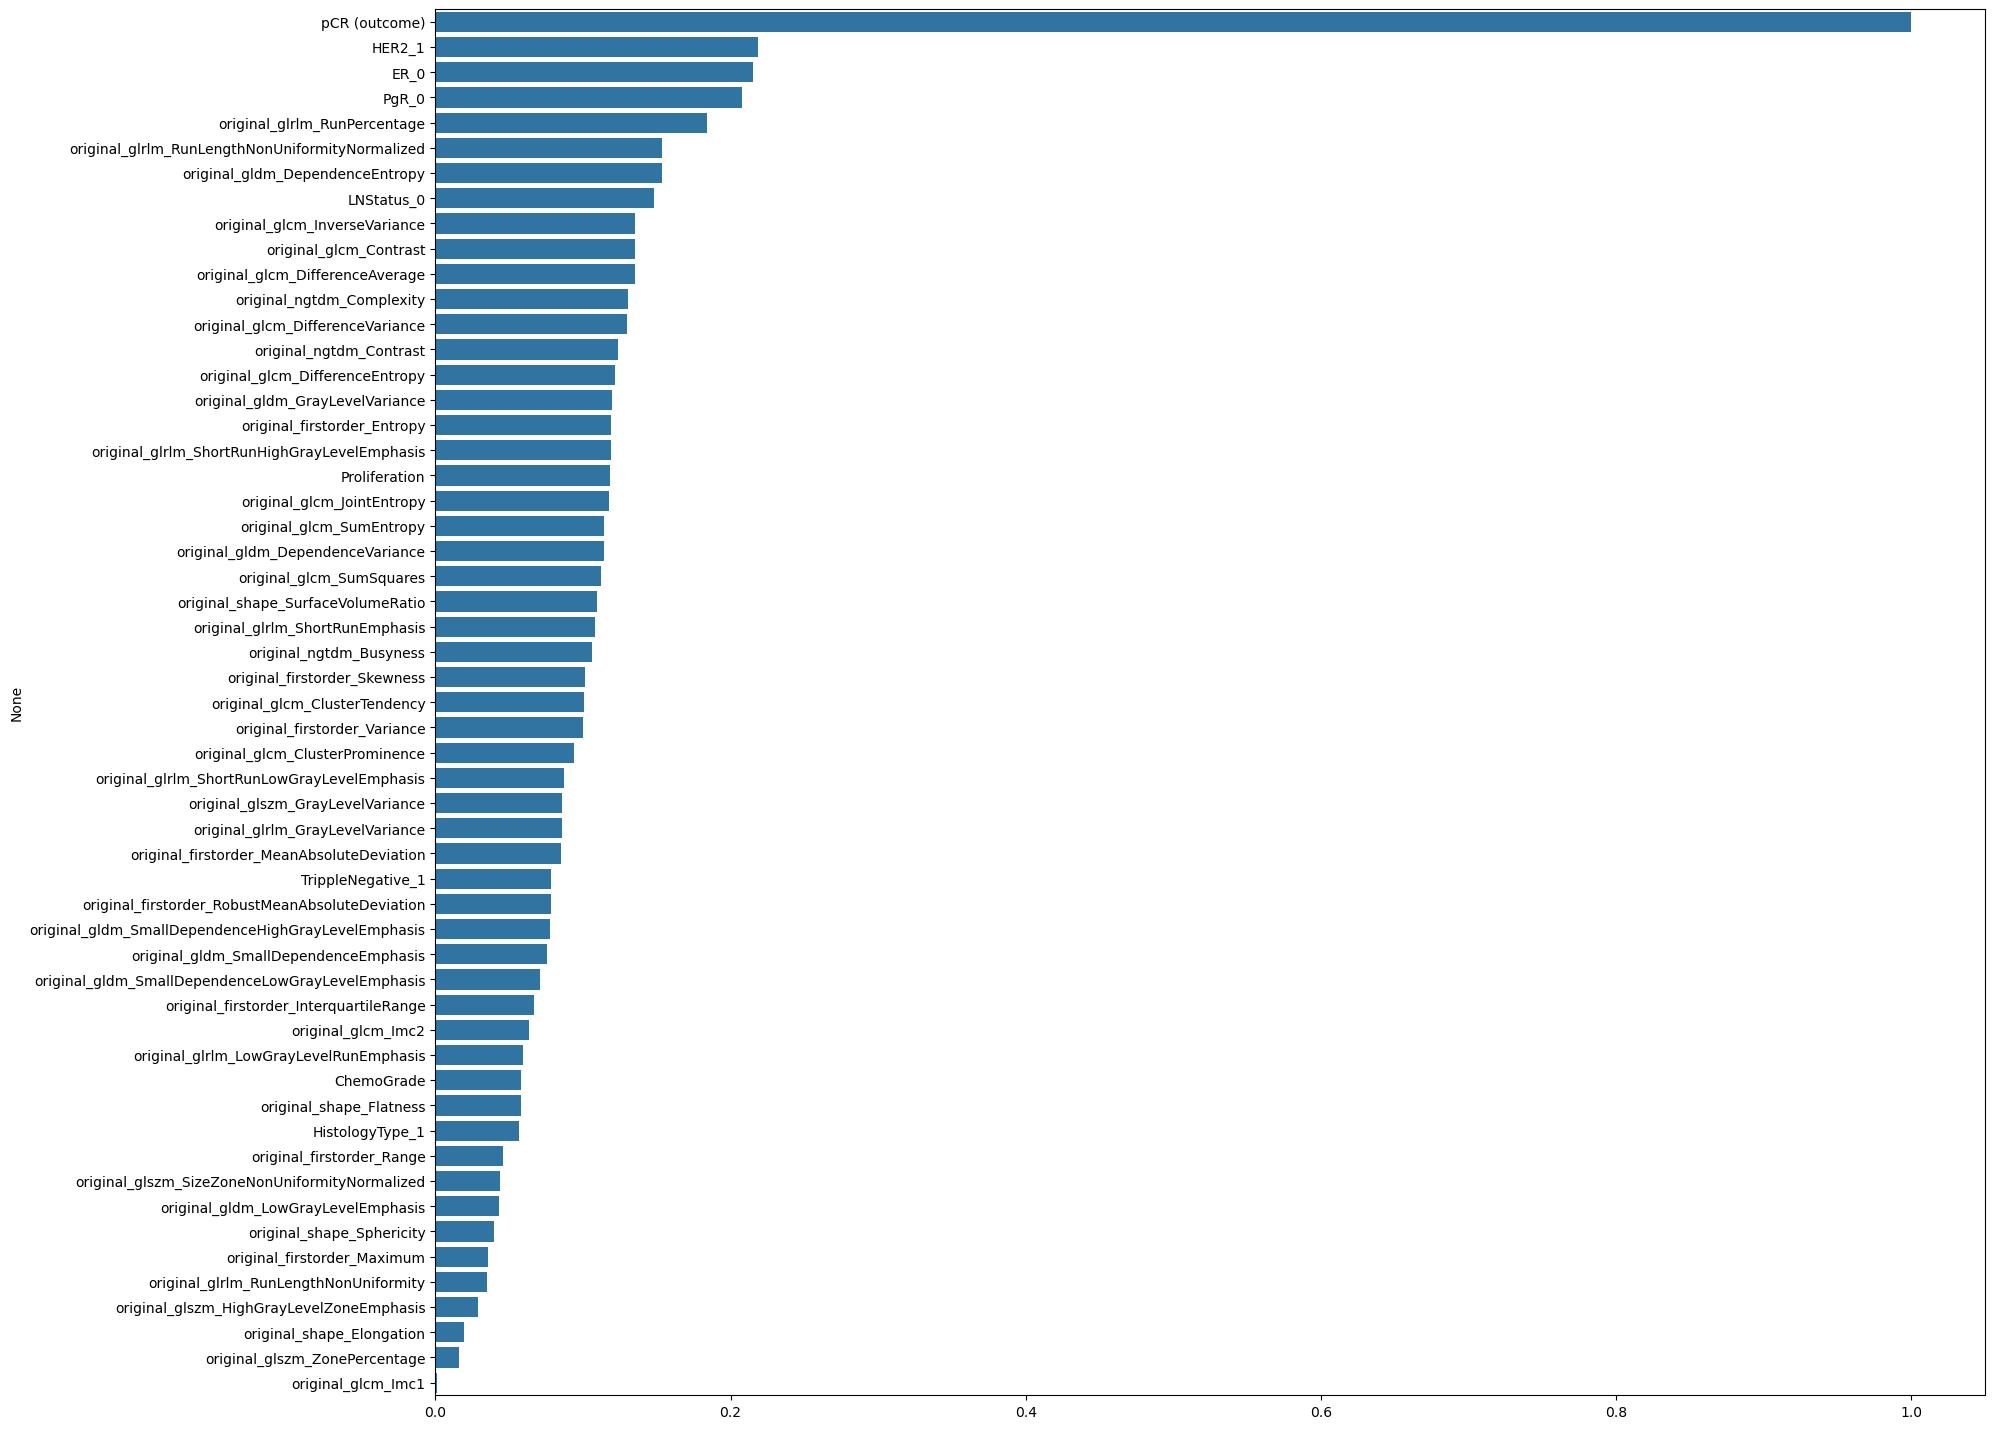

In [191]:
# target = ['pCR (outcome)', 'RelapseFreeSurvival (outcome)' ]
target = ['pCR (outcome)']

high_corr_lst = []
for idx in range(len(target)):
    if idx == 0:
        df = pd.concat([df, pCR_label],axis=1)
    else:
        df = pd.concat([df, RelapseFreeSurvival_label], axis=1)
    corr_matrix = df.corr()
    
    threshold = 0.00 #0.00

    col = corr_matrix[target[idx]] >= threshold
    high_corr_columns = corr_matrix.columns[col]
    high_corr_lst.append(high_corr_columns)

    high_corr_matrix = df[high_corr_columns].corr()
    # print(high_corr_matrix)
    order = high_corr_matrix.loc[target[idx]].sort_values(ascending=False).index

    plt.figure(figsize=(20, 18))
    sns.barplot(x=high_corr_matrix.loc[target[idx]].loc[order].values, y=order)
    plt.show()


In [192]:
len(high_corr_lst[0])
df_high_corr = df[high_corr_columns]

In [193]:
df_high_corr.drop(['pCR (outcome)'], inplace=True, axis=1)
# df_high_corr.drop(['pCR (outcome)'], axis=1)

/var/folders/84/7sr2mg_16zz4cbrvj8yg9w600000gn/T/ipykernel_66392/2828494699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_corr.drop(['pCR (outcome)'], inplace=True, axis=1)


In [194]:
df_high_corr

,ChemoGrade,Proliferation,original_shape_Elongation,original_shape_Flatness,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,...,original_glszm_ZonePercentage,original_ngtdm_Busyness,original_ngtdm_Complexity,original_ngtdm_Contrast,ER_0,PgR_0,HER2_1,TrippleNegative_1,HistologyType_1,LNStatus_0
0,2,2,0.797297,0.807835,0.843485,0.173167,0.809830,0.079285,0.034601,0.000000,...,0.204145,0.022801,0.640530,0.502250,True,True,False,True,True,False
1,2,2,0.622626,0.487408,0.617438,0.275973,0.197378,0.190898,0.220220,0.159700,...,0.496269,0.002864,0.112285,0.016557,False,False,False,False,True,False
2,1,0,0.597765,0.640311,0.623758,0.316123,0.149420,0.114904,0.218491,0.088120,...,0.597166,0.001634,0.084398,0.008716,True,True,False,True,True,True
3,2,2,0.746394,0.519793,0.444105,0.290049,0.095607,0.194394,0.132099,0.118780,...,0.331763,0.002257,0.048078,0.002923,True,True,False,True,True,False
4,1,0,0.852989,0.841683,0.822724,0.245059,0.201519,0.210715,0.055958,0.122448,...,0.576747,0.001908,0.119775,0.017836,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2,1,0.295630,0.222072,0.577849,0.405083,0.119319,0.171265,0.145889,0.113169,...,0.285167,0.000894,0.063282,0.004736,False,True,True,False,True,False
396,2,2,0.917529,0.811094,0.614837,0.417651,0.767629,0.507728,0.184457,0.449797,...,0.375002,0.007543,0.477078,0.364630,True,True,False,True,True,True
397,1,0,0.612128,0.449973,0.707049,0.817894,0.046960,0.442117,0.195426,0.343148,...,0.329379,0.000048,0.025884,0.000616,True,True,False,True,True,True
398,2,2,0.887548,0.954371,0.826109,0.107688,0.416100,0.238754,0.145665,0.199073,...,0.097768,0.009866,0.189627,0.060858,False,True,False,False,True,False


In [195]:
high_corr_X = df_high_corr.values
high_corr_y = pCR_label.values

high_corr_X =high_corr_X.astype(np.float32)  
high_corr_y =high_corr_y.astype(np.int64) 

In [196]:
X_train, X_test, y_train, y_test = train_test_split(high_corr_X, high_corr_y, test_size=0.2, random_state=42)

`Test data sampling`

In [197]:
# X_test, y_test = RandomOverSampler().fit_resample(X_test, y_test)

In [198]:
# df2 = pd.DataFrame({
#     'y_': y_test,  
# })
# df2['y_'].value_counts().plot(kind='bar')
# plt.show()

`Train data Sampling`

In [199]:
X_resampled, y_resampled = RandomOverSampler().fit_resample(X_train, y_train)

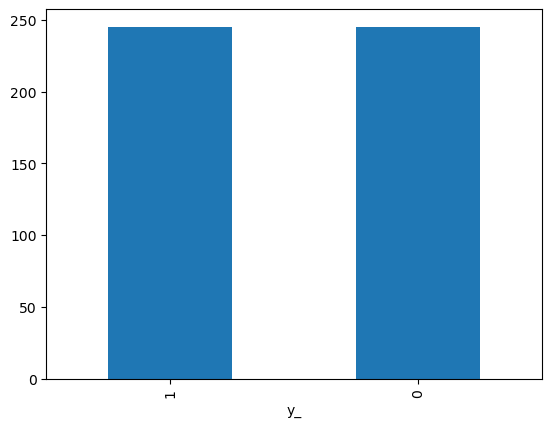

In [200]:
df2 = pd.DataFrame({
    'y_': y_resampled,  
})
df2['y_'].value_counts().plot(kind='bar')
plt.show()

`Sampling with only train data and no K-fold`

train_loss:0.6982309222221375
train_loss:0.6954857707023621
train_loss:0.6950300931930542
train_loss:0.6947717070579529
train_loss:0.6937643885612488
train_loss:0.69077068567276
train_loss:0.6910713911056519
train_loss:0.691193699836731
train_loss:0.6900456547737122
train_loss:0.6894562244415283
train_loss:0.686210572719574
train_loss:0.6877672076225281
train_loss:0.6861122846603394
train_loss:0.6835485100746155
train_loss:0.6818628907203674
train_loss:0.681645393371582
train_loss:0.6788333654403687
train_loss:0.6796501874923706
train_loss:0.6800135374069214
train_loss:0.6778517961502075
train_loss:0.6740669012069702
train_loss:0.6713894009590149
train_loss:0.6712003946304321
train_loss:0.6680744886398315
train_loss:0.6673630475997925
train_loss:0.6692556738853455
train_loss:0.6617466807365417
train_loss:0.6604123711585999
train_loss:0.6607300043106079
train_loss:0.6550717949867249
train_loss:0.6542623043060303
train_loss:0.6502927541732788
train_loss:0.6459578275680542
train_loss:0.64

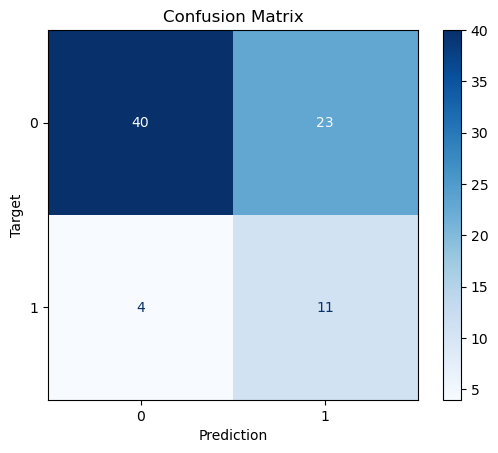

AVG Acc: 0.6538461538461539
AVG Precision: 0.3235294117647059
AVG Recall: 0.7333333333333333
AVG F1 Score: 0.4489795918367347
AVG Balanced Acc: 0.6841269841269841


In [201]:
epochs = 60
lr = 0.001
input_shape = X_resampled.shape[1]
criterion = nn.CrossEntropyLoss()


acc_lst = []
precision_lst = []
recall_lst = []
f1_score_lst = []
confusion_matrice = [] 
balanced_acc_lst = []   
    
X_train_tensor = torch.FloatTensor(X_resampled)
y_train_tensor = torch.LongTensor(y_resampled)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

model = MLP2(input_shape)
# optimizer = optim.Adam(model.parameters(), lr=lr) 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.00) 

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'train_loss:{loss}')

with torch.no_grad():
    model.eval()
    val_loss = 0

    outputs = model(X_test_tensor)
    predicted = torch.argmax(outputs, dim=1)
    validation_outputs = model(X_test_tensor)
    val_losses = criterion(validation_outputs, y_test_tensor)
    print(f'val_losses:{val_losses}')        
    
    acc = accuracy_score(y_test_tensor, predicted)
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    cm = confusion_matrix(y_test_tensor, predicted)
    balanced_acc = balanced_accuracy_score(y_test_tensor, predicted) 

    acc_lst.append(acc)
    precision_lst.append(precision)
    recall_lst.append(recall)
    f1_score_lst.append(f1)
    confusion_matrice.append(cm)
    balanced_acc_lst.append(balanced_acc)  

    print(f' Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')

avg_confusion_matrix = np.mean(confusion_matrice, axis=0).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion_matrix, display_labels=np.unique(y_resampled))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

print(f'AVG Acc: {np.mean(acc_lst)}')
print(f'AVG Precision: {np.mean(precision_lst)}')
print(f'AVG Recall: {np.mean(recall_lst)}')
print(f'AVG F1 Score: {np.mean(f1_score_lst)}')
print(f'AVG Balanced Acc: {np.mean(balanced_acc_lst)}') 




`Sampling train&test data with k-fold`

train_loss:0.691972017288208
train_loss:0.6909710764884949
train_loss:0.6899570822715759
train_loss:0.6890883445739746
train_loss:0.6875364184379578
train_loss:0.6872589588165283
train_loss:0.6867151260375977
train_loss:0.6865752339363098
train_loss:0.6860860586166382
train_loss:0.6859100461006165
train_loss:0.683455228805542
train_loss:0.6831228137016296
train_loss:0.6808153390884399
train_loss:0.682567834854126
train_loss:0.6839684247970581
train_loss:0.6789747476577759
train_loss:0.6788248419761658
train_loss:0.6754178404808044
train_loss:0.6772928833961487
train_loss:0.6758292317390442
train_loss:0.6720184087753296
train_loss:0.6727969646453857
train_loss:0.6719768047332764
train_loss:0.6668535470962524
train_loss:0.6681159138679504
train_loss:0.6648160815238953
train_loss:0.6661925911903381
train_loss:0.6628813743591309
train_loss:0.6582964062690735
train_loss:0.661797285079956
train_loss:0.6636337041854858
train_loss:0.6493303179740906
train_loss:0.6547269821166992
train_loss:0.6

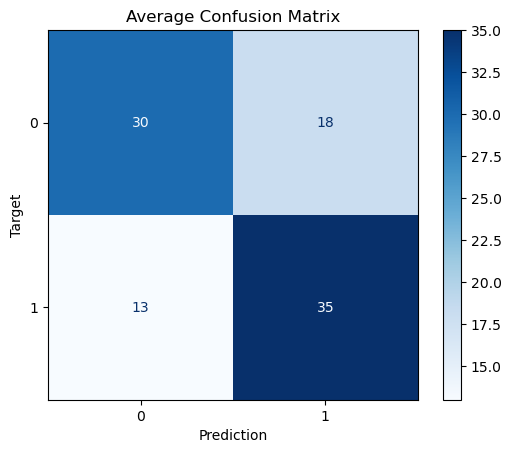

AVG Acc: 0.6775510204081632
AVG Precision: 0.6636875646098849
AVG Recall: 0.7280753700036551
AVG F1 Score: 0.6898268605100902
AVG Balanced Acc: 0.6801067215358236


In [202]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

epochs = 60
lr = 0.001
input_shape = X_resampled.shape[1]
criterion = nn.CrossEntropyLoss()

acc_lst = []
precision_lst = []
recall_lst = []
f1_score_lst = []
confusion_matrice = []
balanced_acc_lst = []  # Add a new list for balanced accuracy

for train_idx, test_idx in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    model = MLP2(input_shape)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.00)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        print(f'train_loss:{loss}')

    with torch.no_grad():
        model.eval()
        val_loss = 0

        outputs = model(X_test_tensor)
        predicted = torch.argmax(outputs, dim=1)
        validation_outputs = model(X_test_tensor)
        val_losses = criterion(validation_outputs, y_test_tensor)
        print(f'val_losses:{val_losses}')

        acc = accuracy_score(y_test_tensor, predicted)
        precision = precision_score(y_test_tensor, predicted)
        recall = recall_score(y_test_tensor, predicted)
        f1 = f1_score(y_test_tensor, predicted)
        cm = confusion_matrix(y_test_tensor, predicted)
        balanced_acc = balanced_accuracy_score(y_test_tensor, predicted)

        acc_lst.append(acc)
        precision_lst.append(precision)
        recall_lst.append(recall)
        f1_score_lst.append(f1)
        confusion_matrice.append(cm)
        balanced_acc_lst.append(balanced_acc)

        print(f' Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}, Balanced Accuracy: {balanced_acc}')

avg_confusion_matrix = np.mean(confusion_matrice, axis=0).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion_matrix, display_labels=np.unique(y_resampled))
disp.plot(cmap="Blues", values_format="d")
plt.title("Average Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

print(f'AVG Acc: {np.mean(acc_lst)}')
print(f'AVG Precision: {np.mean(precision_lst)}')
print(f'AVG Recall: {np.mean(recall_lst)}')
print(f'AVG F1 Score: {np.mean(f1_score_lst)}')
print(f'AVG Balanced Acc: {np.mean(balanced_acc_lst)}')